In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


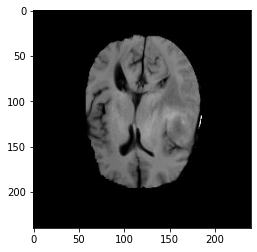

In [ ]:
Data= '/content/drive/MyDrive/Capstone/Project_Design/Data_Set/Training'

img=(cv2.imread('/content/drive/MyDrive/Capstone/Project_Design/Data_Set/Training/1/1.jpg',0))
plt.imshow(img, cmap='gray')

In [ ]:
image_shape=img.shape
image_shape

(240, 240)

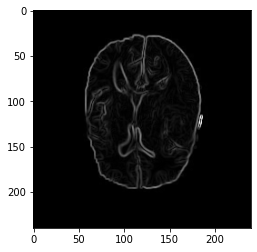

In [ ]:
#Making sure Sobel will work, sobel edge detection will normalize the image
from skimage.filters import sobel, roberts, scharr, prewitt

sobel_img=sobel(img)
plt.imshow(sobel_img, cmap='gray')

Normal Data Set - Sobel

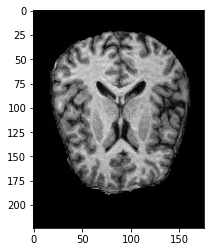

In [ ]:
#Put all the normal images onto a single Data Set Matrix
Normal_Data_set=[]
for i in range(1,50):
  Normal_Data_set.append((cv2.imread(Data + '/0/'+ str(i) +'.jpg',0)))

plt.imshow(Normal_Data_set[25],cmap='gray')

In [ ]:
#This is (heigh, width) of the original picture
Normal_Data_set[25].shape

(224, 176)

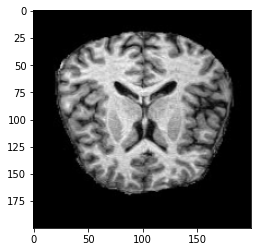

In [ ]:
#I've made the standard (200,200) to throw out any confusion on pixel heigh and width order. 
img=cv2.resize(Normal_Data_set[25],dsize=(200,200))
plt.imshow(img,cmap='gray')

In [ ]:
#Create a Data Set for the Normal Brain Scans. They've been resized to (200,200) for uniformity. 
Normal_Data_set=[]
for i in range(1,201):
  Normal_Data_set.append(cv2.resize((sobel(cv2.imread(Data + '/0/'+ str(i) +'.jpg',0))),dsize=(200,200)))

In [ ]:
len(Normal_Data_set)

200

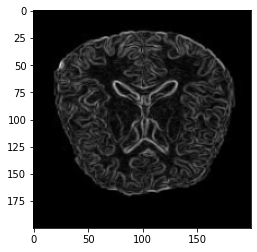

In [ ]:
plt.imshow(Normal_Data_set[25], cmap='gray')

Abnormal Data Set - w/ Sobel and w/o Sobel

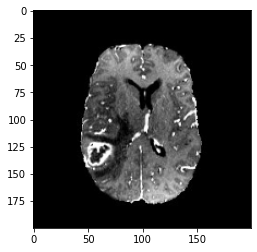

In [ ]:
#Test out how to resizing will look
Abnormal_Data_set=[]
for i in range(1,50):
  Abnormal_Data_set.append(cv2.imread(Data + '/1/'+ str(i) +'.jpg',0))

#The cv2 resize does (width, height) so I have to flip the desired HxW
img=cv2.resize(Abnormal_Data_set[48],dsize=(200,200))
plt.imshow(img,cmap='gray')

In [ ]:
#Create one single Data Set for the Abnormal Brain Scans. They've been resized to (200,200) for uniformity. 
Abnormal_Data_set=[]
for i in range(1,201):
  Abnormal_Data_set.append(cv2.resize((sobel(cv2.imread(Data + '/1/'+ str(i) +'.jpg',0))),dsize=(200,200)))

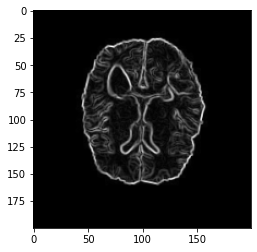

In [ ]:
#Check that image could be reconstructed from the set.
plt.imshow(Abnormal_Data_set[6], cmap='gray')

In [ ]:
len(Normal_Data_set)

200

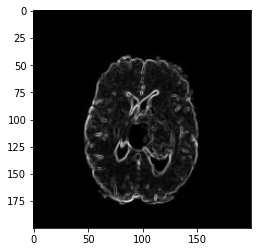

In [ ]:
plt.imshow(Abnormal_Data_set[100], cmap='gray')

In [ ]:
#Separate Train/Val/Test for sobel Data Set
Sobel_Data_set=np.vstack((Normal_Data_set,Abnormal_Data_set))

Sobel_Data_set=Sobel_Data_set.reshape(400,200,200,1)

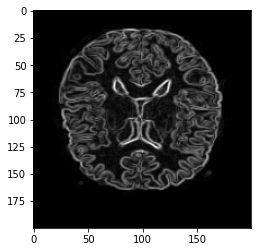

In [ ]:
#Make sure the data set has been shuffled
plt.imshow(Sobel_Data_set[20].reshape(200,200), cmap='gray')

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
#Creating a label array
label_1=np.zeros((1,200))
label_2=np.ones((1,200))

label=np.hstack((label_1,label_2))

label=label[0]
len(label)

400

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Creating Testing DataSet for sobel images

In [ ]:
dir='/content/drive/MyDrive/Capstone/Project_Design/Data_Set/Testing'
Abnormal_test_set=[]
for i in range(1,31):
  Abnormal_test_set.append(cv2.resize((sobel(cv2.imread(Data + '/1/'+ str(i) +'.jpg',0))),dsize=(200,200)))

Normal_test_set=[]
for i in range(1,31):
  Normal_test_set.append(cv2.resize((sobel(cv2.imread(Data + '/0/'+ str(i) +'.jpg',0))),dsize=(200,200)))

Test_Data_set=[]

Test_Data_set=np.vstack((Normal_test_set,Abnormal_test_set))
Test_Data_set=Test_Data_set.reshape(60,200,200,1)

#Create the Labels
test_label_1=np.zeros((1,30))
test_label_2=np.ones((1,30))

test_label=np.hstack((test_label_1,test_label_2))

test_label=test_label[0]

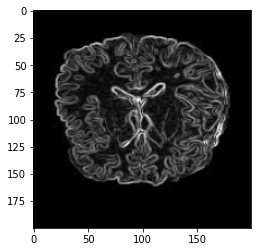

In [ ]:
plt.imshow(Test_Data_set[10].reshape(200,200), cmap='gray')

In [ ]:
#Sets up the standard sizes for the images
img_height=200
img_width=200
batch_size=3

Create the Convolutional Neural Network

In [ ]:
#Create the CNN model
model = keras.Sequential([
                          layers.InputLayer((200, 200, 1)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,3, activation='relu'),
                          layers.MaxPool2D(),
                          layers.Conv2D(128,3, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(2),

])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam', #keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       7

In [ ]:
#Load the numpy array as a training set
full_sobel_ds = tf.data.Dataset.from_tensor_slices((Sobel_Data_set, label))
full_sobel_ds

#Load numpy array as testing set
test_sobel_ds = tf.data.Dataset.from_tensor_slices((Test_Data_set, test_label))
test_sobel_ds = test_sobel_ds.batch(batch_size)

In [ ]:
SHUFFLE_BUFFER_SIZE = 400

full_sobel_ds = full_sobel_ds.shuffle(SHUFFLE_BUFFER_SIZE)

In [ ]:
#Separate Train and Test
Dataset_size=400

train_size = int(0.7 * Dataset_size)
val_size = int(0.3 * Dataset_size)

train_sobel_ds = full_sobel_ds.take(train_size)
val_sobel_ds = full_sobel_ds.skip(train_size)

train_sobel_ds = train_sobel_ds.batch(batch_size)
val_sobel_ds = val_sobel_ds.batch(batch_size)

In [ ]:
history= model.fit(train_sobel_ds,
                   validation_data=val_sobel_ds,
                   epochs=5)

Epoch 1/5
94/94 [==============================] - 15s 148ms/step - loss: 0.5138 - accuracy: 0.8107 - val_loss: 0.3385 - val_accuracy: 0.8833
Epoch 2/5
94/94 [==============================] - 14s 151ms/step - loss: 0.3210 - accuracy: 0.8750 - val_loss: 0.2564 - val_accuracy: 0.9250
Epoch 3/5
94/94 [==============================] - 14s 150ms/step - loss: 0.2216 - accuracy: 0.9143 - val_loss: 0.0975 - val_accuracy: 0.9667
Epoch 4/5
94/94 [==============================] - 14s 151ms/step - loss: 0.1548 - accuracy: 0.9429 - val_loss: 0.1658 - val_accuracy: 0.9250
Epoch 5/5
94/94 [==============================] - 14s 148ms/step - loss: 0.1389 - accuracy: 0.9500 - val_loss: 0.0537 - val_accuracy: 0.9750


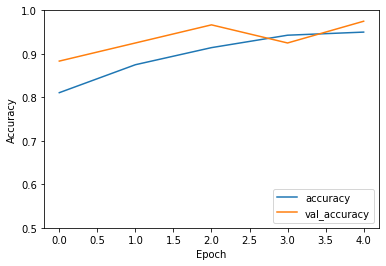

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

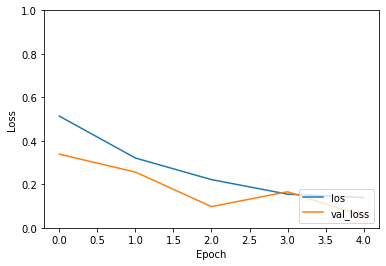

In [ ]:
plt.plot(history.history['loss'], label='los')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(Test_Data_set,test_label, batch_size=batch_size)

20/20 [==============================] - 1s 34ms/step - loss: 0.0798 - accuracy: 0.9833


Trying the training again with new augmented images to add more images to each class

In [ ]:
#Create the CNN model
model_sobel_aug = keras.Sequential([
                          layers.InputLayer((200, 200, 1)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,3, activation='relu'),
                          layers.MaxPool2D(),
                          layers.Conv2D(128,3, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(2),

])

model_sobel_aug.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam', #keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'],
)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

sobel_aug_ds=data_augmentation(Sobel_Data_set)
Train_Data_set=tf.concat([Sobel_Data_set, sobel_aug_ds], 0)

train_label=np.hstack((label,label))
train_label.shape

(800,)

In [ ]:
#Load the numpy array as a training set
aug_full_sobel_ds = tf.data.Dataset.from_tensor_slices((Train_Data_set, train_label))

AUG_SHUFFLE_BUFFER_SIZE = 800

aug_full_sobel_ds = aug_full_sobel_ds.shuffle(AUG_SHUFFLE_BUFFER_SIZE)

In [ ]:
#Separate Train and Test
Dataset_size=800

train_size = int(0.7 * Dataset_size)
val_size = int(0.3 * Dataset_size)

aug_train_sobel_ds = aug_full_sobel_ds.take(train_size)
aug_val_sobel_ds = aug_full_sobel_ds.skip(train_size)

aug_train_sobel_ds = aug_train_sobel_ds.batch(batch_size)
aug_val_sobel_ds = aug_val_sobel_ds.batch(batch_size)

In [ ]:
history= model_sobel_aug.fit(aug_train_sobel_ds,
                   validation_data=aug_val_sobel_ds,
                   epochs=10)

Epoch 1/10
187/187 [==============================] - 29s 150ms/step - loss: 0.5824 - accuracy: 0.7321 - val_loss: 0.5167 - val_accuracy: 0.8250
Epoch 2/10
187/187 [==============================] - 28s 150ms/step - loss: 0.4167 - accuracy: 0.8232 - val_loss: 0.3031 - val_accuracy: 0.8792
Epoch 3/10
187/187 [==============================] - 28s 148ms/step - loss: 0.3244 - accuracy: 0.8589 - val_loss: 0.2581 - val_accuracy: 0.8792
Epoch 4/10
187/187 [==============================] - 28s 151ms/step - loss: 0.2611 - accuracy: 0.8964 - val_loss: 0.1925 - val_accuracy: 0.9333
Epoch 5/10
187/187 [==============================] - 28s 147ms/step - loss: 0.2167 - accuracy: 0.9107 - val_loss: 0.1569 - val_accuracy: 0.9667
Epoch 6/10
187/187 [==============================] - 29s 155ms/step - loss: 0.1594 - accuracy: 0.9411 - val_loss: 0.0968 - val_accuracy: 0.9667
Epoch 7/10
187/187 [==============================] - 29s 155ms/step - loss: 0.0873 - accuracy: 0.9732 - val_loss: 0.1894 - val_ac

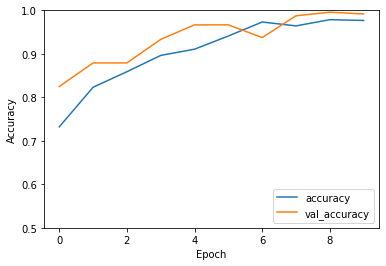

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

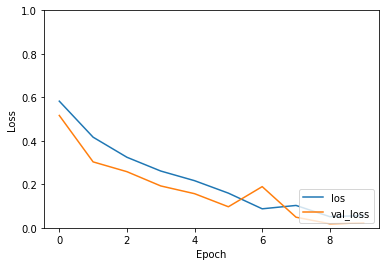

In [ ]:
plt.plot(history.history['loss'], label='los')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model_sobel_aug.evaluate(Test_Data_set,test_label, batch_size=batch_size)

20/20 [==============================] - 1s 37ms/step - loss: 0.0073 - accuracy: 1.0000


Try to do the k-fold validation, lets say 3-k folds

In [ ]:
#Create the CNN model
model_1 = keras.Sequential([
                          layers.InputLayer((200, 200, 1)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,3, activation='relu'),
                          layers.MaxPool2D(),
                          layers.Conv2D(128,3, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(2),

])

model_1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam', #keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'],
)

#Create the CNN model
model_2 = keras.Sequential([
                          layers.InputLayer((200, 200, 1)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,3, activation='relu'),
                          layers.MaxPool2D(),
                          layers.Conv2D(128,3, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(2),

])

model_2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam', #keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'],
)

#Create the CNN model
model_3 = keras.Sequential([
                          layers.InputLayer((200, 200, 1)),
                          layers.Conv2D(16, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32, 3, padding='same', activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,3, activation='relu'),
                          layers.MaxPool2D(),
                          layers.Conv2D(128,3, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(2),

])

model_3.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam', #keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'],
)

In [ ]:
aug_full_sobel_ds = aug_full_sobel_ds.shuffle(800)

In [ ]:
#Separate Train and Test
Dataset_size=800

k= int(0.33 * Dataset_size)

k_1 = aug_full_sobel_ds.take(k)
pt_2 = aug_full_sobel_ds.skip(k)
k_2=pt_2.take(k)
k_3=pt_2.skip(k)

k_1 = k_1.batch(batch_size)
k_2 = k_2.batch(batch_size)
k_3 = k_3.batch(batch_size)

In [ ]:
ds_1 = k_1.concatenate(k_2) #Use k_3 as validation
ds_2 = k_1.concatenate(k_3) #Use k_2 as validation
ds_3 = k_2.concatenate(k_3) #Use k_1 as validation

In [ ]:
model_1.fit(ds_1,
                   validation_data=k_3,
                   epochs=4)

Epoch 1/4
176/176 [==============================] - 28s 157ms/step - loss: 0.5446 - accuracy: 0.7614 - val_loss: 0.5210 - val_accuracy: 0.8015
Epoch 2/4
176/176 [==============================] - 27s 152ms/step - loss: 0.3894 - accuracy: 0.8409 - val_loss: 0.2815 - val_accuracy: 0.8603
Epoch 3/4
176/176 [==============================] - 27s 153ms/step - loss: 0.2801 - accuracy: 0.8883 - val_loss: 0.2079 - val_accuracy: 0.9154
Epoch 4/4
176/176 [==============================] - 27s 153ms/step - loss: 0.2594 - accuracy: 0.8958 - val_loss: 0.2178 - val_accuracy: 0.8971


In [ ]:
model_1.evaluate(Test_Data_set,test_label, batch_size=batch_size)

20/20 [==============================] - 1s 35ms/step - loss: 0.1398 - accuracy: 0.9333


[0.13983522355556488, 0.9333333373069763]

In [ ]:
model_2.fit(ds_2,
                   validation_data=k_2,
                   epochs=4)

Epoch 1/4
179/179 [==============================] - 28s 153ms/step - loss: 0.6347 - accuracy: 0.7052 - val_loss: 0.3532 - val_accuracy: 0.8561
Epoch 2/4
179/179 [==============================] - 26s 148ms/step - loss: 0.3925 - accuracy: 0.8340 - val_loss: 0.2670 - val_accuracy: 0.8674
Epoch 3/4
179/179 [==============================] - 27s 153ms/step - loss: 0.2564 - accuracy: 0.8862 - val_loss: 0.1306 - val_accuracy: 0.9470
Epoch 4/4
179/179 [==============================] - 27s 150ms/step - loss: 0.1989 - accuracy: 0.9179 - val_loss: 0.1388 - val_accuracy: 0.9432


In [ ]:
model_2.evaluate(Test_Data_set,test_label, batch_size=batch_size)

20/20 [==============================] - 1s 44ms/step - loss: 0.0680 - accuracy: 0.9833


[0.06803598999977112, 0.9833333492279053]

In [ ]:
model_3.fit(ds_3,
                   validation_data=k_1,
                   epochs=3)

Epoch 1/3
179/179 [==============================] - 28s 153ms/step - loss: 0.5528 - accuracy: 0.7463 - val_loss: 0.3765 - val_accuracy: 0.8295
Epoch 2/3
179/179 [==============================] - 28s 154ms/step - loss: 0.4085 - accuracy: 0.8284 - val_loss: 0.2912 - val_accuracy: 0.8864
Epoch 3/3
179/179 [==============================] - 27s 152ms/step - loss: 0.3121 - accuracy: 0.8713 - val_loss: 0.2212 - val_accuracy: 0.9318


In [ ]:
model_3.evaluate(Test_Data_set,test_label, batch_size=batch_size)

20/20 [==============================] - 1s 36ms/step - loss: 0.3410 - accuracy: 0.8500


[0.34098008275032043, 0.8500000238418579]

In [ ]:
accuracy=round(((0.8958+0.9432+0.8713)/3),3)
loss=round(((0.2594+0.1989+0.3121)/3),3)

val_acc=round(((0.8971+0.9179+0.9318)/3),3)
val_loss=round(((0.2178+0.1388+0.2212)/3),3)

test_acc=round(((0.9333+0.9833+0.8500)/3),3)
test_loss=round(((0.1398+0.0860+0.3410)/3),3)

In [ ]:
print('The kfold training accuracy and loss are: ' +str(accuracy*100) +' ' + str(loss))
print('The kfold validation accuracy and loss are: ' +str(val_acc*100) +' ' + str(val_loss))
print('The kfold testing accuracy and loss are: ' +str(test_acc*100) +' ' + str(test_loss))

The kfold training accuracy and loss are: 90.3 0.257
The kfold validation accuracy and loss are: 91.60000000000001 0.193
The kfold testing accuracy and loss are: 92.2 0.189
